In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2, vgg16
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import cifar10

from PIL import Image

dataset

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

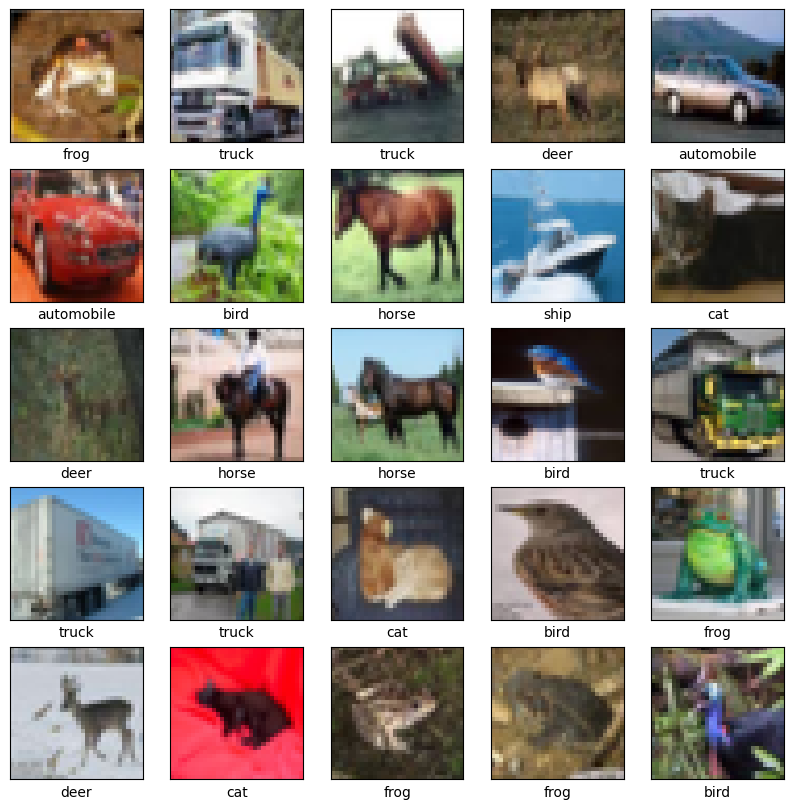

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

model

In [6]:
### MobileNetV2

base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add our own classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

/var/folders/dl/zl_0g6_x5rj940xy30q6_pgw0000gn/T/ipykernel_15356/391407910.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')


Epoch 1/10


KeyboardInterrupt: 

In [41]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

313/313 - 5s - 17ms/step - accuracy: 0.3159 - loss: 1.8941
Test accuracy: 0.3158999979496002


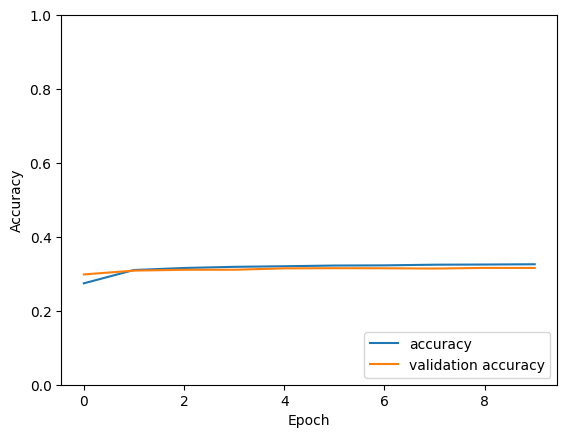

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Step 1: Prepare image embeddings

In [18]:
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image

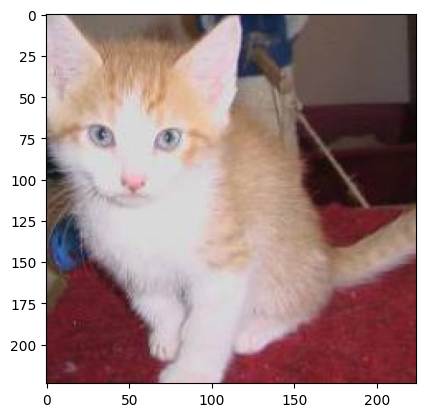

In [19]:
# Open the image file
img = Image.open("cat.jpg")

# Display the image (optional)
plt.imshow(img)

In [20]:
# Convert image to array and expand dimensions to match batch shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

In [21]:
# Load the pre-trained ResNet50 model without the classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Define the feature extraction model
model = models.Model(inputs=base_model.input, outputs=base_model.output)

In [22]:
img_features = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [23]:
flattened_features = img_features.flatten()
print(f"Feature map shape: {img_features.shape}")  # Typically (1, 7, 7, 2048)
print(f"Flattened feature vector shape: {flattened_features.shape}")  # Shape: (100352,)

Feature map shape: (1, 7, 7, 2048)
Flattened feature vector shape: (100352,)


step 2: textual embedding

In [24]:
from transformers import BertTokenizer, TFBertModel

In [25]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [26]:
# Define the input question
question = "Is there a cat in the image?"

# Tokenize the input question
inputs = tokenizer(question, return_tensors="tf", padding=True, truncation=True, max_length=32)

# Extract input IDs and attention mask
input_ids = inputs['input_ids']  # Shape: [1, sequence_length]
attention_mask = inputs['attention_mask']  # Shape: [1, sequence_length]

In [27]:
# Pass inputs through BERT
outputs = model(input_ids, attention_mask=attention_mask)

# Get the last hidden state (all token embeddings)
last_hidden_state = outputs.last_hidden_state  # Shape: (1, sequence_length, 768)

# Extract the [CLS] token embedding for sentence-level representation
text_features = last_hidden_state[:, 0, :]  # Shape: (1, 768)

In [28]:
# Convert to numpy array (optional)
text_features = text_features.numpy()
print(f"Textual embedding shape: {text_features.shape}")  # Shape: (1, 768)

Textual embedding shape: (1, 768)


Step 3: Multimodal Fusion  (NOT WORKING YET)

In [29]:
img_features.shape, text_features.shape

((1, 7, 7, 2048), (1, 768))

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

In [31]:
# Visual features input with shape (1, 7, 7, 2048)
visual_input = Input(shape=(7, 7, 2048), name="visual_input")

# Textual features input with shape (1, 768)
text_input = Input(shape=(768,), name="text_input")

In [32]:
# Apply Global Average Pooling to convert to (1, 2048)
pooled_features = GlobalAveragePooling2D()(visual_input)  # Shape: (None, 2048)

In [33]:
# Concatenate visual and textual features
fused_features = Concatenate()([pooled_features, text_input])  # Shape: (None, 2048 + 768)

In [34]:
# Project fused features to a joint embedding space
fused_embedding = Dense(1024, activation="relu")(fused_features)

# Optional: Apply dropout for regularization
fused_embedding = Dropout(0.3)(fused_embedding)

print(f"Fused embedding shape: {fused_embedding.shape}")  # Expected: (None, 1024)

Fused embedding shape: (None, 1024)


In [35]:
# Create the fusion model
fusion_model = Model(inputs=[visual_input, text_input], outputs=fused_embedding)

# Compile the model (optional for training, if needed)
fusion_model.compile(optimizer="adam", loss="mse")

# Model summary to visualize architecture
fusion_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ visual_input        │ (None, 7, 7,      │          0 │ -                 │
│ (InputLayer)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ visual_input[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2816)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,884,608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,884,608 (11.00 MB)

 Trainable params: 2,884,608 (11.00 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Convert features to TensorFlow tensors
img_features_tensor = tf.convert_to_tensor(img_features, dtype=tf.float32)
text_features_tensor = tf.convert_to_tensor(text_features, dtype=tf.float32)

# Get the fused embedding
fused_output = fusion_model.predict([img_features_tensor, text_features_tensor])

print(f"Fused output shape: {fused_output.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Fused output shape: (1, 1024)


step 4: answer generation

In [38]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf

In [39]:
# Load T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [43]:
prompt = question
print(f"Generated prompt: {prompt}")

Generated prompt: Is there a cat in the image?


In [44]:
# Encode the prompt for T5
input_ids = tokenizer(prompt, return_tensors="tf").input_ids

# Generate answer using T5
output_ids = model.generate(input_ids, max_length=50, num_return_sequences=1, early_stopping=True)

# Decode the generated output to get the final answer
answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(f"Generated Answer: {answer}")

/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
I0000 00:00:1742488707.307740  302230 service.cc:152] XLA service 0x3063f32d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742488707.309155  302230 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-03-20 11:38:27.400290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742488707.845079  302230 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

Generated Answer: Ist es ein Katz in der image?
